In [2]:
# Import the required libraries and dependencies
import pandas as pd
import hvplot.pandas
from pathlib import Path
from sklearn.linear_model import LinearRegression

In [5]:
file_loc = "../Resources/complaints-2024-12-01_16_26.csv."
data = pd.read_csv(file_loc)

# Display basic information about the dataset
data_info = {
    "shape": data.shape,
    "columns": data.columns.tolist(),
    "sample": data.head()
}

data_info

{'shape': (101776, 18),
 'columns': ['Date received',
  'Product',
  'Sub-product',
  'Issue',
  'Sub-issue',
  'Consumer complaint narrative',
  'Company public response',
  'Company',
  'State',
  'ZIP code',
  'Tags',
  'Consumer consent provided?',
  'Submitted via',
  'Date sent to company',
  'Company response to consumer',
  'Timely response?',
  'Consumer disputed?',
  'Complaint ID'],
 'sample':   Date received                                            Product  \
 0      09/23/24  Credit reporting or other personal consumer re...   
 1      09/23/24  Credit reporting or other personal consumer re...   
 2      09/16/24                                    Debt collection   
 3      10/13/24  Credit reporting or other personal consumer re...   
 4      09/14/24                                    Debt collection   
 
         Sub-product                                              Issue  \
 0  Credit reporting  Problem with a company's investigation into an...   
 1  Credit repo

##  Data Cleaning & Preprocessing

In [6]:
# Check for missing values in the dataset
missing_values_summary = data.isnull().sum()

# Summarize categorical column distributions to assess their potential for modeling
categorical_columns = data.select_dtypes(include=['object']).columns
categorical_summary = {col: data[col].value_counts().head(5).to_dict() for col in categorical_columns}

# Display the missing values and categorical column summaries
{
    "missing_values": missing_values_summary
}


{'missing_values': Date received                        0
 Product                              0
 Sub-product                          0
 Issue                                0
 Sub-issue                         2104
 Consumer complaint narrative         0
 Company public response          38824
 Company                              0
 State                              414
 ZIP code                             0
 Tags                             95014
 Consumer consent provided?           0
 Submitted via                        0
 Date sent to company                 0
 Company response to consumer         0
 Timely response?                     0
 Consumer disputed?              101776
 Complaint ID                         0
 dtype: int64}

In [7]:
# Display the categorical column summaries
{"categorical_summary": categorical_summary}

{'categorical_summary': {'Date received': {'09/19/24': 3358,
   '09/04/24': 3357,
   '09/26/24': 3326,
   '09/17/24': 3316,
   '09/03/24': 3308},
  'Product': {'Credit reporting or other personal consumer reports': 80569,
   'Debt collection': 7964,
   'Credit card': 4067,
   'Checking or savings account': 3789,
   'Mortgage': 1664},
  'Sub-product': {'Credit reporting': 80103,
   'I do not know': 3966,
   'General-purpose credit card or charge card': 3416,
   'Checking account': 3070,
   'Credit card debt': 1402},
  'Issue': {'Incorrect information on your report': 41036,
   'Improper use of your report': 20965,
   "Problem with a company's investigation into an existing problem": 17828,
   'Attempts to collect debt not owed': 3753,
   'Managing an account': 2190},
  'Sub-issue': {'Information belongs to someone else': 20445,
   'Reporting company used your report improperly': 14824,
   'Their investigation did not fix an error on your report': 8899,
   'Account status incorrect': 763

In [8]:
from sklearn.preprocessing import LabelEncoder

# Drop columns that are completely missing or irrelevant for analysis
data_cleaned = data.drop(columns=["Consumer disputed?"], errors="ignore")

# Fill missing values for categorical columns with a placeholder
categorical_columns = data_cleaned.select_dtypes(include=['object']).columns
data_cleaned[categorical_columns] = data_cleaned[categorical_columns].fillna("Missing")

# Encode target variables for supervised learning
label_encoders = {}
for col in ["Timely response?", "Company response to consumer"]:
    if col in data_cleaned.columns:
        le = LabelEncoder()
        data_cleaned[col] = le.fit_transform(data_cleaned[col])
        label_encoders[col] = le

# Confirm cleaned dataset
cleaned_summary = {
    "shape": data_cleaned.shape,
    "missing_values": data_cleaned.isnull().sum().sum(),
    "sample": data_cleaned.head()
}
cleaned_summary

{'shape': (101776, 17),
 'missing_values': 0,
 'sample':   Date received                                            Product  \
 0      09/23/24  Credit reporting or other personal consumer re...   
 1      09/23/24  Credit reporting or other personal consumer re...   
 2      09/16/24                                    Debt collection   
 3      10/13/24  Credit reporting or other personal consumer re...   
 4      09/14/24                                    Debt collection   
 
         Sub-product                                              Issue  \
 0  Credit reporting  Problem with a company's investigation into an...   
 1  Credit reporting                        Improper use of your report   
 2      Medical debt                 False statements or representation   
 3  Credit reporting                        Improper use of your report   
 4  Credit card debt  Took or threatened to take negative or legal a...   
 
                                            Sub-issue  \
 0     

##  Supervised Learning - Classification

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Features and target for supervised learning
features = ["Product", "Issue", "Consumer complaint narrative"]
target = "Timely response?"

# Filter rows where narrative is not "Missing" for text analysis
data_supervised = data_cleaned[data_cleaned["Consumer complaint narrative"] != "Missing"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_supervised[features],
    data_supervised[target],
    test_size=0.2,
    random_state=42,
    stratify=data_supervised[target]
)

# Define transformers for categorical and text data
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
text_transformer = TfidfVectorizer(max_features=500)

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, ["Product", "Issue"]),
        ("text", text_transformer, "Consumer complaint narrative")
    ]
)

# Create a pipeline with a RandomForestClassifier
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
supervised_results = {
    "accuracy": accuracy_score(y_test, y_pred),
    "classification_report": classification_report(y_test, y_pred)
}
supervised_results

{'accuracy': 0.9954107388710418,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00        19\n           1       1.00      1.00      1.00      4339\n\n    accuracy                           1.00      4358\n   macro avg       0.50      0.50      0.50      4358\nweighted avg       0.99      1.00      0.99      4358\n'}

## Unsupervised Learning

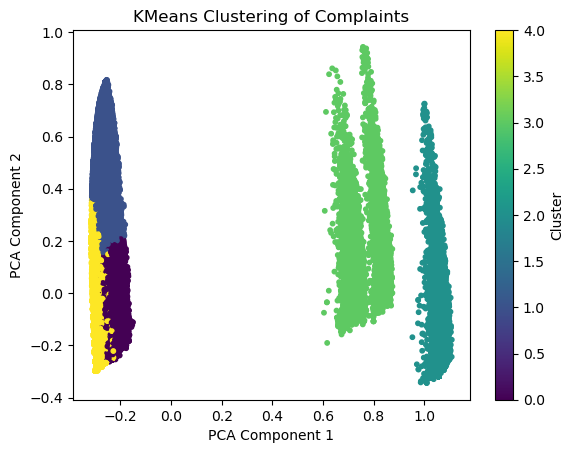

0    54454
1    16301
3    13243
4     9814
2     7964
Name: count, dtype: int64

In [11]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Use a subset of columns for clustering (excluding labels)
clustering_features = data_cleaned[["Product", "Issue", "Consumer complaint narrative"]]

# Encode categorical features and preprocess text
categorical_features = ["Product"]
text_feature = "Consumer complaint narrative"

# Preprocess categorical features using one-hot encoding
categorical_encoded = pd.get_dummies(clustering_features[categorical_features])

# Preprocess text feature using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
text_encoded = tfidf.fit_transform(clustering_features[text_feature])

# Combine encoded features
from scipy.sparse import hstack
combined_features = hstack([categorical_encoded.values, text_encoded])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(combined_features)

# Visualize clusters using PCA (reduce to 2D)
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(combined_features.toarray())
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', s=10)
plt.title("KMeans Clustering of Complaints")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

# Display cluster distribution
cluster_counts = pd.Series(clusters).value_counts()
cluster_counts